In [ ]:
from tensorflow.keras.datasets import cifar10,cifar100
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model, Input, utils,regularizers
from matplotlib.pyplot import imshow, show
import numpy as np
from cv2 import imread, imwrite, resize
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2, MobileNet, mobilenet_v3
from tensorflow import concat, reshape, GradientTape
from tensorflow.keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from tensorflow import one_hot
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
import h5py

In [ ]:
class HierarchicalModel(Model):
    def __init__(self, inputs, outputs):
        super().__init__(inputs, outputs)

    # def compile(self, optimizer, lamb, sigma, metrics=None,**kwargs):
    #     super(HierarchicalModel, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
    #     self.lamb = lamb
    #     self.sigma = sigma

    def set_hyper(self, lamb=0.5, sigma=0.8):
        self.lamb = lamb
        self.sigma = sigma

    #overwrite train_step function to customize
    def train_step(self, data):
        x, y = data
        y_true_category = y['category']
        y_true_grade = y['grade']
        with GradientTape() as tape:
            [y_pred_category, y_pred_grade] = self(x, training=True)
            category_loss = categorical_crossentropy(y_true_category, y_pred_category)
            grade_loss = categorical_crossentropy(y_true_grade, y_pred_grade)

            correct_category = tf.reduce_all(tf.equal(tf.argmax(y_true_category, axis=1), tf.argmax(y_pred_category, axis=1)), axis=-1)
            correct_grade = tf.reduce_all(tf.equal(tf.argmax(y_true_grade, axis=1), tf.argmax(y_pred_grade, axis=1)),axis=-1)
            both_correct = tf.cast(correct_category & correct_grade, tf.float32)
            penalty = 1.0 - both_correct  # 1 if either is wrong, 0 if both are correct

            #customize loss funtion
            combined_loss = (1 - self.lamb) * category_loss + self.lamb * grade_loss + self.sigma * penalty * (category_loss*grade_loss)

        # Compute gradients
        gradients = tape.gradient(combined_loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, [y_pred_category, y_pred_grade])

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [ ]:
def backbone_model(
    image_shape = (224, 224 , 3),
    category_depth = 9,
    trainable = False):

    #Create MobilenetV3Small Backbone

    '''
    image_shape - the shape of the input images
    category_depth - the position of the layer where we using as the input of category
    trainable - whether to train the backbone or not
    ************************************
    return - A model that outputs the encoding for category classification task and grading task
    '''

    backbone = MobileNetV3Small(
                    input_shape= image_shape,
                    include_top= False,
                    weights= 'imagenet',
                    input_tensor= None,
                    dropout_rate= 0.2,
                    include_preprocessing= True)

    backbone.trainable = trainable

    grade_input = backbone.get_layer(backbone.layers[-1].name).output

    category_input = backbone.get_layer(f'expanded_conv_{str(category_depth)}/Add').output

    return Model(inputs = backbone.input, outputs = [grade_input, category_input])


In [ ]:
def hierarchical_model(
    image_shape = (224, 224 , 3),
    category_depth = 9,
    category_num = 2,
    grade_num = 2,
    L2 = 0):

    '''
    image_shape - the shape of the input images
    category_depth - the position of the layer where we using as the input of category
    category_num - number of output nodes or number of classes for category classification task
    grade_num - number of output nodes or number of classes for grading task
    L2 - L2 regularization coefficient
    ************************************
    return - A model that outputs the probabilities for both category and grading task
    '''


    #initialize the backbone model
    backbone = backbone_model(
    image_shape = image_shape,
    category_depth = category_depth,
    trainable = False)

    backbone.trainable = False

    input = Input(shape = image_shape)

    [grade_input, category_input] = backbone(input, training = False)

    #category classification task
    x_category = tfl.Flatten()(category_input)
    x_category = tfl.Dropout(0.4)(x_category)
    x_category = tfl.Dense(256, activation = 'relu', kernel_regularizer= regularizers.l2(L2))(x_category)
    x_category = tfl.Dropout(0.3)(x_category)
    x_category = tfl.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2))(x_category)
    x_category = tfl.Dropout(0.2)(x_category)
    category_output = tfl.Dense(category_num, activation = 'softmax', name = 'category', kernel_regularizer=regularizers.l2(L2))(x_category)

    #quality grading task
    x_grade = tfl.Flatten()(grade_input)
    x_grade = tfl.Dropout(0.5)(x_grade)
    x_grade = tfl.Dense((100), activation='relu', kernel_regularizer=regularizers.l2(L2*4))(x_grade)
    x_grade = tfl.Dropout(0.4)(x_grade)
    x_grade = tfl.Dense((16), activation = 'relu', kernel_regularizer= regularizers.l2(L2*4))(x_grade)
    x_grade = tfl.Dropout(0.125)(x_grade)
    x_grade = concat([x_grade, category_output], -1)
    grade_output = tfl.Dense(grade_num, activation = 'softmax', name = 'grade', kernel_regularizer= regularizers.l2(L2*4))(x_grade)

    model = HierarchicalModel(inputs = input, outputs = [category_output, grade_output])

    return model

In [ ]:
file_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/TRAIN DATA/hierachical_6_3_224x224_30350.h5'

with h5py.File(file_path, 'r') as hf:
    x_train = hf['images'][()]
    y_category = hf['labels'][()]
    y_grade = hf['qualities'][()]
print(x_train.shape)
print(y_category.shape)
print(y_grade.shape)

category_num = len(set(y_category))
grade_num = len(set(y_grade))

print(category_num)
print(grade_num)

(30350, 224, 224, 3)
(30350,)
(30350,)
6
3


In [ ]:
y_category_onehot = np.array(reshape(one_hot(y_category,category_num),(-1,category_num)))
y_grade_onehot = np.array(reshape(one_hot(y_grade,grade_num),(-1,grade_num)))

del y_category
del y_grade

X_train, X_test, y_category_train, y_category_test, y_grade_train, y_grade_test = train_test_split(
    x_train, y_category_onehot, y_grade_onehot, test_size=0.2, random_state=42
)

del x_train
del y_category_onehot
del y_grade_onehot

In [ ]:
train_dataset = Dataset.from_tensor_slices((X_train, {'category': y_category_train, 'grade': y_grade_train}))
train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(32)

del X_train
del y_category_train
del y_grade_train

In [ ]:
test_dataset = Dataset.from_tensor_slices((X_test, {'category': y_category_test, 'grade': y_grade_test}))
test_dataset = test_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(32)

del X_test
del y_category_test
del y_grade_test

In [ ]:
model = hierarchical_model(category_num=category_num, grade_num=grade_num, L2=0.3)
model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "hierarchical_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 7, 7, 576),          939120    ['input_2[0][0]']             
                              (None, 7, 7, 96)]                                                   
                                                                                                  
 flatten (Flatten)           (None, 4704)                 0         ['model[0][1]']               
                                                                                                  
 dropout (Dropout)

In [ ]:
lr_schedule = ExponentialDecay(
    6e-5,
    decay_steps=3000,
    decay_rate=0.8,
    staircase=True
)
model.compile(optimizer = Adam(learning_rate=2e-5), loss={'category': 'categorical_crossentropy', 'grade': 'categorical_crossentropy'}, metrics = ['accuracy'])
model.set_hyper(lamb=1, sigma=0)
history_1 = model.fit(train_dataset, epochs = 30)

Epoch 1/30
759/759 [==============================] - 12s 9ms/step - category_accuracy: 0.1588 - grade_accuracy: 0.5403
Epoch 2/30
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.1482 - grade_accuracy: 0.6613
Epoch 3/30
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.1526 - grade_accuracy: 0.7114
Epoch 4/30
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.1510 - grade_accuracy: 0.7421
Epoch 5/30
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.1506 - grade_accuracy: 0.7674
Epoch 6/30
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.1565 - grade_accuracy: 0.7875
Epoch 7/30
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.1577 - grade_accuracy: 0.8028
Epoch 8/30
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.1637 - grade_accuracy: 0.8157
Epoch 9/30
759/759 [===========================

In [ ]:
print(history_1.history)

In [ ]:
import tensorflow as tf
def overall_accuracy(y_true, y_pred):
    #this accuracy is used to validate if the model can successfully predict the label for both category classification task and quality grading task

    # Unpack true labels
    y_true_category = y_true[0]
    y_true_grade = y_true[1]

    # Unpack predicted labels
    y_pred_category = y_pred[0]
    y_pred_grade = y_pred[1]

    # Get the predicted class (highest probability) for both outputs
    y_pred_category = tf.argmax(y_pred_category, axis=-1)
    y_pred_grade = tf.argmax(y_pred_grade, axis=-1)

    # Get the true class for both outputs
    y_true_category = tf.argmax(y_true_category, axis=-1)
    y_true_grade = tf.argmax(y_true_grade, axis=-1)

    # Compare both predictions with true labels
    is_correct_category = tf.equal(y_pred_category, y_true_category)
    is_correct_grade = tf.equal(y_pred_grade, y_true_grade)

    # Only count as correct if both category and grade are correct
    is_correct = tf.logical_and(is_correct_category, is_correct_grade)
    # Convert boolean tensor to float and take the mean to get accuracy
    return tf.reduce_mean(tf.cast(is_correct, tf.float32))

def category_accuracy(y_true, y_pred):
    y_true_category = tf.argmax(y_true, axis=-1)
    y_pred_category = tf.argmax(y_pred, axis=-1)
    is_true = tf.equal(y_true_category, y_pred_category)
    return tf.reduce_mean(tf.cast(is_true, tf.float32))

def grade_accuracy(y_true, y_pred):
    y_true_grade = tf.argmax(y_true, axis=-1)
    y_pred_grade = tf.argmax(y_pred, axis=-1)
    is_true = tf.equal(y_true_grade, y_pred_grade)
    return tf.reduce_mean(tf.cast(is_true, tf.float32))


In [ ]:
all_X = []
all_y_category = []
all_y_grade = []
count = 0
# Iterate over the dataset to collect all data and labels
for batch in test_dataset:
    X, y = batch  # Unpack the batch into X (inputs) and y (labels)

    # Collect batch of inputs
    all_X.append(X.numpy())  # Assuming X is a TensorFlow tensor, convert to NumPy if needed

    # Collect batch of labels
    all_y_category.append(y['category'].numpy())  # Assuming y['category'] is a TensorFlow tensor
    all_y_grade.append(y['grade'].numpy())  # Assuming y['grade'] is a TensorFlow tensor
    count += 1

print(count)
# Concatenate all batches into single arrays or lists
all_X = tf.concat(all_X, axis=0)  # Concatenate along batch dimension if X is a tensor
all_y_category = tf.concat(all_y_category, axis=0)  # Concatenate along batch dimension if y['category'] is a tensor
all_y_grade = tf.concat(all_y_grade, axis=0)  # Concatenate along batch dimension if y['grade'] is a tensor
print(all_X.shape)
print(all_y_category.shape)
print(all_y_grade.shape)

190
(6070, 224, 224, 3)
(6070, 6)
(6070, 3)


In [ ]:
model.evaluate(test_dataset)
outputs = model.predict(all_X)
[pred_category, pred_grade] = outputs
print(pred_category.shape)
print(pred_grade.shape)

print('Overall_accuracy :', overall_accuracy([all_y_category,all_y_grade], [pred_category, pred_grade]).numpy())
print('Category_accuracy :',category_accuracy(all_y_category, pred_category).numpy())
print('Grade_accuracy :',category_accuracy(all_y_grade, pred_grade).numpy())

190/190 [==============================] - 2s 7ms/step
(6070, 6)
(6070, 3)
Overall_accuracy : 0.89901155
Category_accuracy : 0.97561777
Grade_accuracy : 0.91878086


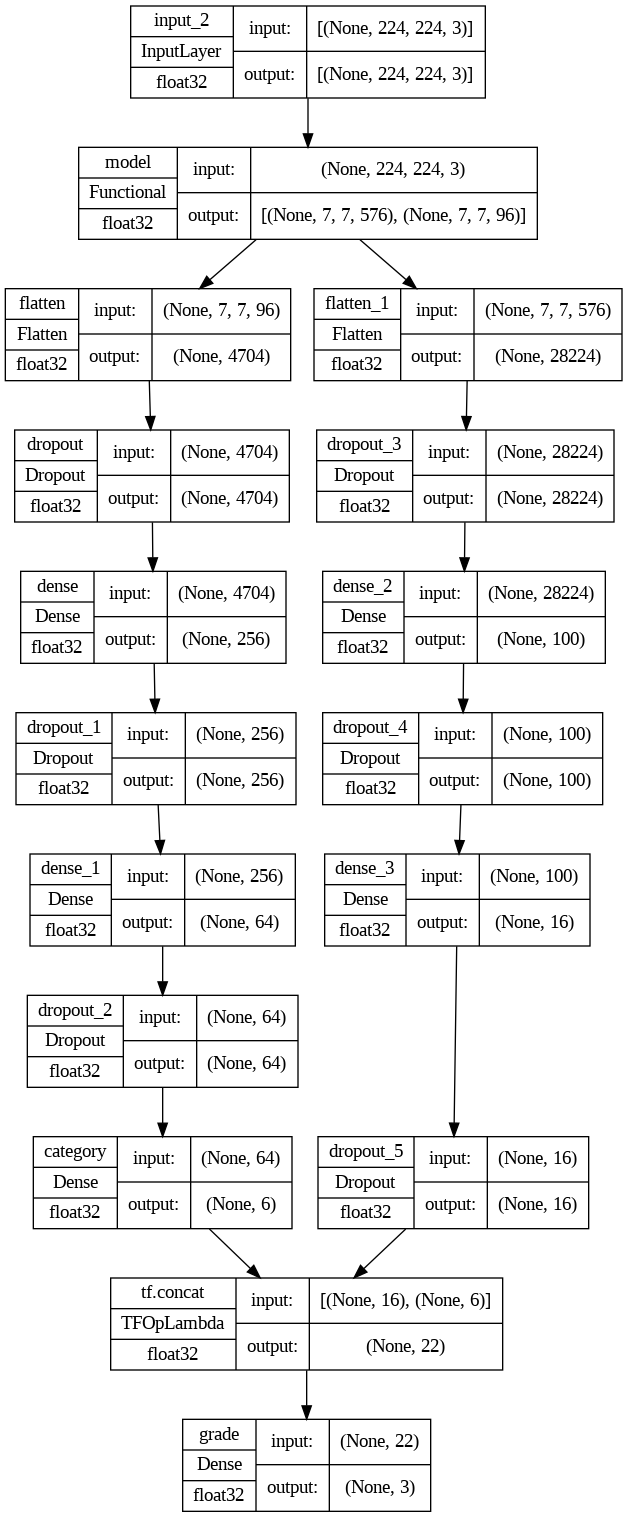

In [ ]:
utils.plot_model(model, show_shapes=True, show_dtype=True)